# 1. Import Dependencies

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# 2. Load Dataset

In [20]:
df = pd.read_csv('./data/kospi.csv')
scaler = MinMaxScaler()
df[['Open', 'High', 'Low', 'Close', 'Volume']] = scaler.fit_transform(df[['Open', 'High', 'Low', 'Close', 'Volume']])

In [21]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-30,0.722898,0.732351,0.745525,0.759235,2206.199951,0.242113
1,2019-01-31,0.763058,0.750069,0.769089,0.757866,2204.850098,0.274771
2,2019-02-01,0.751894,0.745714,0.769280,0.756456,2203.459961,0.241609
3,2019-02-07,0.755809,0.742538,0.764596,0.756415,2203.419922,0.215603
4,2019-02-08,0.731584,0.717777,0.739548,0.729669,2177.050049,0.197057


In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [23]:
device

device(type='cuda', index=0)

In [24]:
X = df[['Open', 'High', 'Low', 'Volume']].values
y = df['Close'].values

In [26]:
def seq_data(x, y, seq_len):
    x_seq = []
    y_seq = []
    for i in range(len(x) - seq_len):
        x_seq.append(x[i : i + seq_len]) # a[2:6] -> 2, 3, 4, 5
        y_seq.append(y[i + seq_len])

    return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1, 1)

In [27]:
split = 200
seq_len = 5

x_seq, y_seq = seq_data(X, y, seq_len)
x_train_seq = x_seq[ : split]
y_train_seq = y_seq[ : split]

x_test_seq = x_seq[split : ]
y_test_seq = y_seq[split : ]

print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())

torch.Size([200, 5, 4]) torch.Size([200, 1])
torch.Size([226, 5, 4]) torch.Size([226, 1])


/tmp/ipykernel_657505/40359000.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1716905979055/work/torch/csrc/utils/tensor_new.cpp:274.)
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1, 1)


In [44]:
train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)

batch_size = 20

train_loader = torch.utils.data.DataLoader(dataset = train, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test, batch_size = batch_size, shuffle = False)

# 3. Construct Model

In [45]:
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

In [46]:
class VanillaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, seq_len, num_layers, device):
        super(VanillaRNN, self).__init__()
        self.device = device
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size * seq_len, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
        out, _ = self.rnn(x, h0)
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)
        return out

In [47]:
model = VanillaRNN(
    input_size = input_size,
    hidden_size = hidden_size,
    seq_len = seq_len,
    num_layers = num_layers,
    device = device).to(device)

In [50]:
import torchsummary
torchsummary.summary(model, input_size = (seq_len, input_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               RNN-1   [[-1, 5, 8], [-1, 2, 8]]               0
            Linear-2                    [-1, 1]              41
           Sigmoid-3                    [-1, 1]               0
Total params: 41
Trainable params: 41
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


In [51]:
criterion = nn.MSELoss()
num_epochs = 301
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [52]:
loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
    running_loss = 0.0

    for data in train_loader:
        seq, target = data
        out = model(seq)
        loss = criterion(out, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    loss_graph.append(running_loss / n)
    if epoch % 100 == 0:
        print(f'[epoch: {epoch}] loss: {(running_loss / n):.4f}')

[epoch: 0] loss: 0.0169
[epoch: 100] loss: 0.0007
[epoch: 200] loss: 0.0005
[epoch: 300] loss: 0.0004


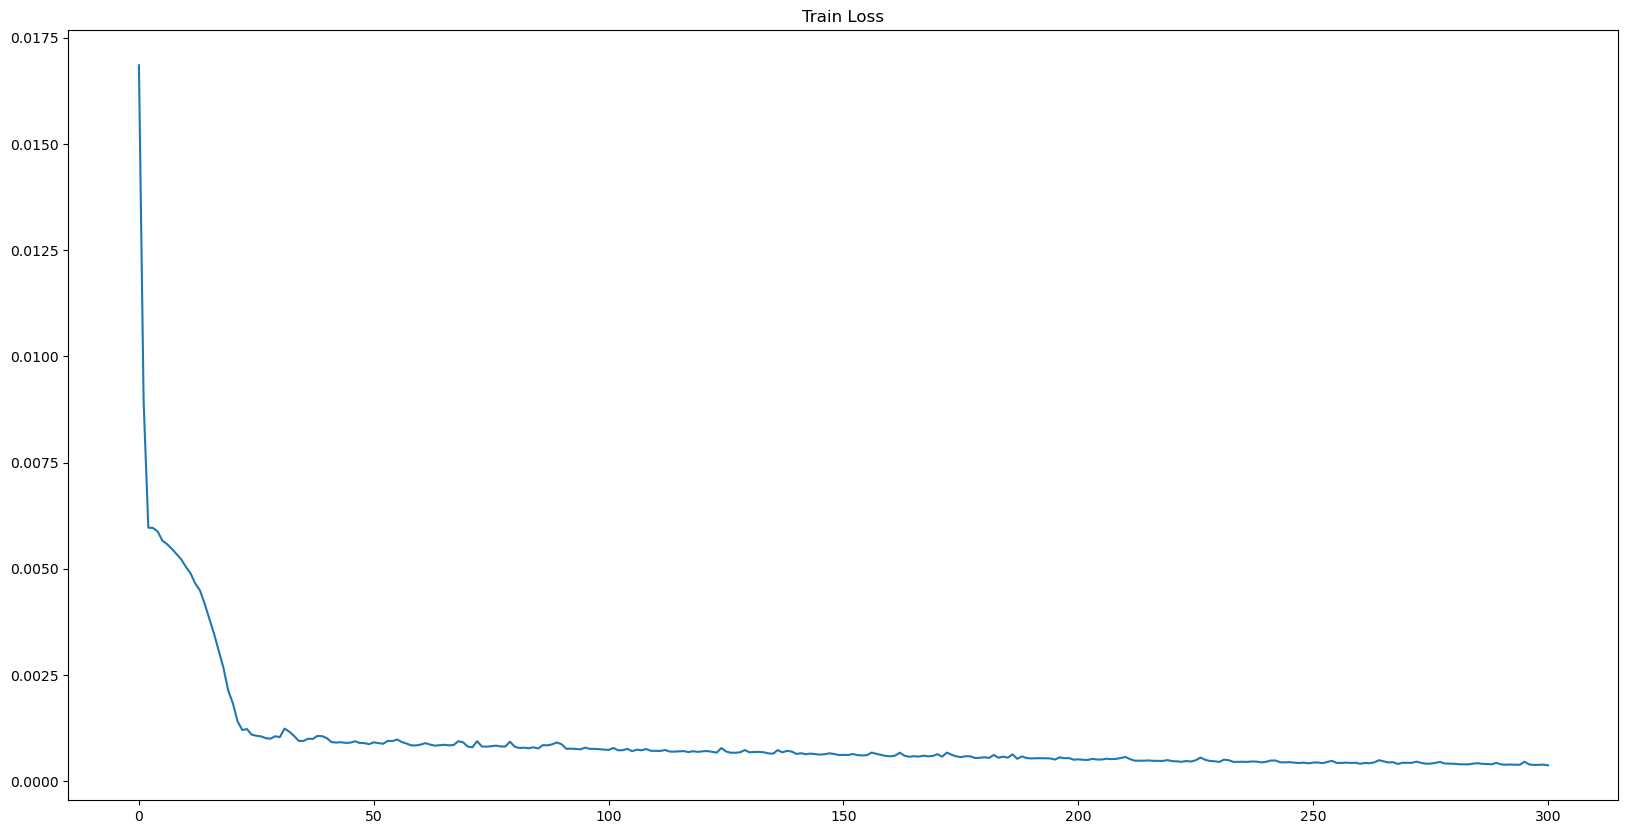

In [53]:
plt.figure(figsize = (20, 10))
plt.plot(loss_graph)

plt.title("Train Loss")
plt.show()

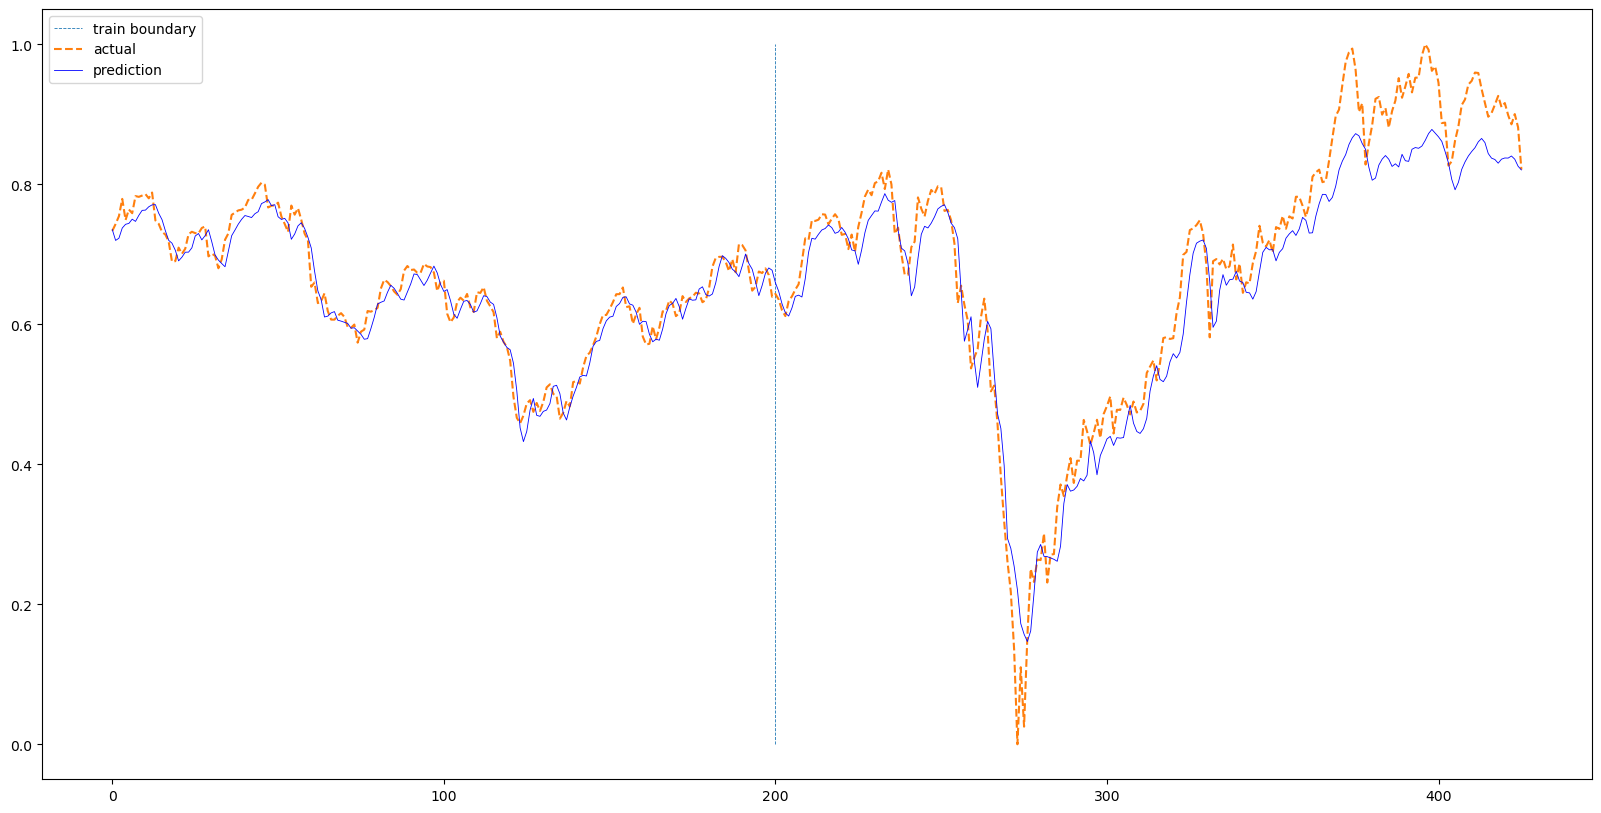

In [54]:
concatdata = torch.utils.data.ConcatDataset([train, test])
data_loader = torch.utils.data.DataLoader(dataset = concatdata, batch_size = 100)
with torch.no_grad():
    pred = []
    model.eval()
    for data in data_loader:
        seq, target = data
        out = model(seq)
        pred += out.cpu().tolist()

plt.figure(figsize = (20, 10))
plt.plot(np.ones(100) * len(train), np.linspace(0, 1, 100), '--', linewidth = 0.6)
plt.plot(df['Close'][seq_len:].values, '--')
plt.plot(pred, 'b', linewidth = 0.6)
plt.legend(['train boundary', 'actual', 'prediction'])
plt.show()